In [4]:
import pandas as pd
import numpy as np
import duckdb
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

DATA_PATH = "../data/processed/citibike/*/*/data.parquet"
con = duckdb.connect("../data/processed/citibike/citibike.duckdb")

def period_of_day(hour: int) -> str:
    if 6 <= hour < 10:
        return "Morning"
    elif 10 <= hour < 16:
        return "Midday"
    elif 16 <= hour < 20:
        return "Evening"
    elif 20 <= hour < 24:
        return "Late Evening"
    else:
        return "Night"


In [5]:
stations = con.execute("""
WITH trips AS (
    SELECT
        start_station_id,
        start_station_name,
        start_lat, start_lng,
        end_station_id,
        end_station_name,
        end_lat, end_lng
    FROM read_parquet($data_path)
),
stations_union AS (
    SELECT start_station_id AS station_id, start_station_name AS station_name,
           start_lat AS lat, start_lng AS lon
    FROM trips
    WHERE start_station_id IS NOT NULL

    UNION

    SELECT end_station_id AS station_id, end_station_name AS station_name,
           end_lat AS lat, end_lng AS lon
    FROM trips
    WHERE end_station_id IS NOT NULL
)
SELECT DISTINCT
    CAST(station_id AS VARCHAR) AS station_id,
    station_name,
    ROUND(lat::DOUBLE, 5) AS lat,
    ROUND(lon::DOUBLE, 5) AS lon
FROM stations_union
ORDER BY station_id
""", {"data_path": DATA_PATH}).df()


In [6]:
collision = pd.read_csv("../data/processed/cleaned_collision_data.csv")
collision["CRASH DATETIME"] = pd.to_datetime(collision["CRASH DATETIME"],
                                             errors="coerce")

# BallTree spatial match
stations_rad = np.radians(stations[["lat", "lon"]].values)
tree = BallTree(stations_rad, metric="haversine")

crash_coords = np.radians(collision[["LATITUDE", "LONGITUDE"]].values)
dist, idx = tree.query(crash_coords, k=1)

collision["nearest_station_id"] = stations.iloc[idx.flatten()].station_id.values
collision["distance_m"] = dist * 6371000


In [7]:
alpha = 0.10

df_station = collision.query("distance_m <= 300").copy()

df_station["risk_cyclist"] = (
    df_station["CYCLIST_INVOLVED"] *
    (1 + 10*df_station["NUMBER OF PERSONS INJURED"]
       + 100*df_station["NUMBER OF PERSONS KILLED"])
)

df_station["risk_non_cyclist"] = (
    (1 - df_station["CYCLIST_INVOLVED"]) *
    (1 + 10*df_station["NUMBER OF PERSONS INJURED"]
       + 100*df_station["NUMBER OF PERSONS KILLED"])
)

risk_raw = (df_station
            .groupby("nearest_station_id")[["risk_cyclist","risk_non_cyclist"]]
            .sum()
            .reset_index())

risk_raw["risk_cyclist_norm"] = risk_raw["risk_cyclist"] / risk_raw["risk_cyclist"].max()
risk_raw["risk_non_cyclist_norm"] = risk_raw["risk_non_cyclist"] / risk_raw["risk_non_cyclist"].max()

risk_raw["risk_norm"] = ((1-alpha)*risk_raw["risk_cyclist_norm"] +
                          alpha*risk_raw["risk_non_cyclist_norm"])

stations_with_risk = (
    stations.merge(risk_raw, left_on="station_id", right_on="nearest_station_id", how="left")
            .fillna({"risk_cyclist_norm": 0, "risk_non_cyclist_norm": 0, "risk_norm": 0})
)


In [8]:
exposure_query = f"""
WITH trips AS (
    SELECT
        CAST(start_station_id AS VARCHAR) AS start_station_id,
        CAST(end_station_id AS VARCHAR) AS end_station_id,
        CAST(started_at AS TIMESTAMP) AS started_at_ts,
        CAST(ended_at AS TIMESTAMP) AS ended_at_ts
    FROM read_parquet('{DATA_PATH}')
),
labeled AS (
    SELECT
        start_station_id AS station_id,
        date_trunc('day', started_at_ts) AS date,
        CASE
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 6 AND 9 THEN 'Morning'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 10 AND 15 THEN 'Midday'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 16 AND 19 THEN 'Evening'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 20 AND 23 THEN 'Late Evening'
            ELSE 'Night'
        END AS period,
        1 AS departures_period,
        0 AS arrivals_period
    FROM trips
    WHERE start_station_id IS NOT NULL

    UNION ALL

    SELECT
        end_station_id AS station_id,
        date_trunc('day', ended_at_ts) AS date,
        CASE
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 6 AND 9 THEN 'Morning'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 10 AND 15 THEN 'Midday'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 16 AND 19 THEN 'Evening'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 20 AND 23 THEN 'Late Evening'
            ELSE 'Night'
        END AS period,
        0 AS departures_period,
        1 AS arrivals_period
    FROM trips
    WHERE end_station_id IS NOT NULL
)
SELECT
    station_id,
    date,
    period,
    SUM(departures_period) AS departures_period,
    SUM(arrivals_period) AS arrivals_period,
    SUM(departures_period + arrivals_period) AS rides_period
FROM labeled
GROUP BY station_id, date, period
"""

exposure_agg = con.execute(exposure_query).df()


In [10]:
alpha = 0.10  # same alpha as in your aggregate station risk

# Only crashes within 300 m of a station
collision_in_radius = collision.query("distance_m <= 300").copy()

# Make sure datetime is proper
collision_in_radius["CRASH DATETIME"] = pd.to_datetime(
    collision_in_radius["CRASH DATETIME"], errors="coerce"
)

# If your cyclist flag column has a space in the name, fix it once:
if "CYCLIST_ INVOLVED" in collision_in_radius.columns and "CYCLIST_INVOLVED" not in collision_in_radius.columns:
    collision_in_radius = collision_in_radius.rename(columns={"CYCLIST_ INVOLVED": "CYCLIST_INVOLVED"})

# Per-crash risk components (same structure as your station-level risk)
collision_in_radius["risk_cyclist"] = (
    collision_in_radius["CYCLIST_INVOLVED"]
    * (1
       + 10 * collision_in_radius["NUMBER OF PERSONS INJURED"]
       + 100 * collision_in_radius["NUMBER OF PERSONS KILLED"])
)

collision_in_radius["risk_non_cyclist"] = (
    (1 - collision_in_radius["CYCLIST_INVOLVED"])
    * (1
       + 10 * collision_in_radius["NUMBER OF PERSONS INJURED"]
       + 100 * collision_in_radius["NUMBER OF PERSONS KILLED"])
)

# Composite per-crash severity used as panel target
collision_in_radius["severity_weight"] = (
    (1 - alpha) * collision_in_radius["risk_cyclist"]
    + alpha       * collision_in_radius["risk_non_cyclist"]
)

# Date + period for grouping
collision_in_radius["date"] = collision_in_radius["CRASH DATETIME"].dt.floor("D")
collision_in_radius["period"] = collision_in_radius["CRASH DATETIME"].dt.hour.map(period_of_day)

# Aggregate to station × day × period
crash_agg = (
    collision_in_radius
    .groupby(["nearest_station_id", "date", "period"])["severity_weight"]
    .sum()
    .reset_index()
    .rename(columns={
        "nearest_station_id": "station_id",
        "severity_weight": "risk_event"
    })
)


In [11]:
# union of station IDs present in exposure or crashes
station_ids = np.union1d(exposure_agg["station_id"].unique(), crash_agg["station_id"].unique())

# date range
min_date = min(exposure_agg["date"].min(), crash_agg["date"].min())
max_date = max(exposure_agg["date"].max(), crash_agg["date"].max())
dates = pd.date_range(min_date, max_date, freq="D")
periods = ["Night", "Morning", "Midday", "Evening", "Late Evening"]

panel_index = pd.MultiIndex.from_product(
    [station_ids, dates, periods],
    names=["station_id", "date", "period"]
)
panel = pd.DataFrame(index=panel_index).reset_index()

# merge exposure + target, calendar + rolling features, etc.


In [12]:
panel = (
    panel
    .merge(exposure_agg, on=["station_id","date","period"], how="left")
    .merge(crash_agg, on=["station_id","date","period"], how="left")
    .fillna({"departures_period":0,"arrivals_period":0,
             "rides_period":0,"risk_event":0})
)

panel["weekday"] = panel["date"].dt.weekday
panel["is_weekend"] = panel["weekday"].isin([5,6]).astype(int)
panel["month"] = panel["date"].dt.month
panel["is_holiday"] = 0
panel = panel.sort_values(["station_id","period","date"])

panel["past_7d_risk"] = (
    panel.groupby(["station_id","period"])["risk_event"]
         .transform(lambda s: s.shift(1).rolling(7, min_periods=1).sum())
)

panel["past_30d_risk"] = (
    panel.groupby(["station_id","period"])["risk_event"]
         .transform(lambda s: s.shift(1).rolling(30, min_periods=1).sum())
)

panel["rides_period_7d_mean"] = (
    panel.groupby(["station_id","period"])["rides_period"]
         .transform(lambda s: s.shift(1).rolling(7, min_periods=1).mean())
)

panel.fillna(0, inplace=True)


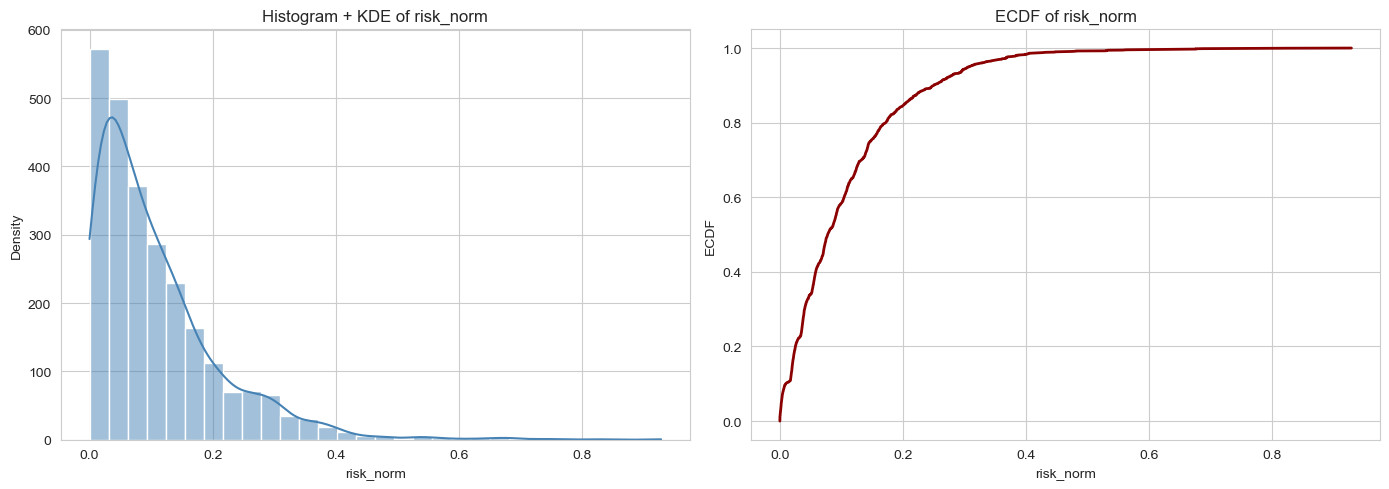

In [13]:
# Visualize the distribution of risk_norm
vals = stations_with_risk["risk_norm"].values


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --------------------------------------------
# LEFT: Histogram + KDE
# --------------------------------------------
sns.histplot(vals, bins=30, kde=True, ax=axes[0], color="steelblue")
axes[0].set_xlabel("risk_norm")
axes[0].set_ylabel("Density")
axes[0].set_title("Histogram + KDE of risk_norm")

# --------------------------------------------
# RIGHT: ECDF
# --------------------------------------------
sorted_vals = np.sort(vals)
ecdf = np.linspace(0, 1, len(sorted_vals))

axes[1].plot(sorted_vals, ecdf, color="darkred", lw=2)
axes[1].set_xlabel("risk_norm")
axes[1].set_ylabel("ECDF")
axes[1].set_title("ECDF of risk_norm")
axes[1].grid(True)

plt.tight_layout()
plt.show()